# tdist estimation proof in javascript

This notebook should act as a proof to the reliability of the javascript estimation. This method is used for plotting confidence intervals on group summary data. Since it's only used for plotting, it doesn't need to be extremely precise.

In [1]:
%matplotlib inline
import json

import numpy as np
import pandas as pd
from scipy.stats import t

## Generate "truth"

In [2]:
dfs = np.arange(1,350)
lowers = t.ppf(0.025, dfs)
uppers = t.ppf(0.975, dfs)

In [3]:
# prove that lowers == uppers *-1; so we dont' need to capture both
assert np.allclose(lowers* -1, uppers) is True

<AxesSubplot:xlabel='df'>

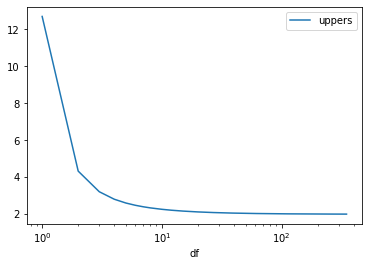

In [4]:
df = pd.DataFrame(data=dict(df=dfs, uppers=t.ppf(0.975, dfs)))
df.plot("df", "uppers", logx=True)

## Translate javascript to python:

As shown in permalink: [source](https://github.com/shapiromatron/bmds-server/blob/792877f8a41aef28781db9232e71a95cbb3e790b/frontend/src/utils/errorBars.js#L3-L59)

```javascript
inv_tdist_05 = function(df) {
    // Calculates the inverse t-distribution using a piecewise linear form for
    // the degrees of freedom specified. Assumes a two-tailed distribution with
    // an alpha of 0.05. Based on curve-fitting using Excel's T.INV.2T function
    // with a maximum absolute error of 0.00924 and percent error of 0.33%.
    //
    // Roughly equivalent to scipy.stats.t.ppf(0.975, df)
    var b;
    if (df < 1) {
        return NaN;
    } else if (df == 1) {
        return 12.7062047361747;
    } else if (df < 12) {
        b = [
            7.9703237683e-5,
            -3.5145890027e-3,
            0.063259191874,
            -0.5963723075,
            3.129413441,
            -8.8538894383,
            13.358101926,
        ];
    } else if (df < 62) {
        b = [
            1.1184055716e-10,
            -2.7885328039e-8,
            2.8618499662e-6,
            -1.5585120701e-4,
            4.8300645273e-3,
            -0.084316656676,
            2.7109288893,
        ];
    } else {
        b = [
            5.1474329765e-16,
            -7.262226388e-13,
            4.2142967681e-10,
            -1.2973354626e-7,
            2.275308052e-5,
            -2.2594979441e-3,
            2.0766977669,
        ];
        if (df > 350) {
            console.warn("Extrapolating beyond inv_tdist_05 regression range (N>350).");
            return undefined;
        }
    }
    return (
        b[0] * Math.pow(df, 6) +
        b[1] * Math.pow(df, 5) +
        b[2] * Math.pow(df, 4) +
        b[3] * Math.pow(df, 3) +
        b[4] * Math.pow(df, 2) +
        b[5] * Math.pow(df, 1) +
        b[6]
    );
}
```

In [5]:
def inv_tdist_05(df):
        
        if df < 1 or df >350:
            raise ValueError()
            
        if df == 1:
            return 12.7062047361747;
        
        if (df < 12):
            b = [
                7.9703237683e-5,
                -3.5145890027e-3,
                0.063259191874,
                -0.5963723075,
                3.129413441,
                -8.8538894383,
                13.358101926,
            ];
            
        elif (df < 62):
            b = [
                1.1184055716e-10,
                -2.7885328039e-8,
                2.8618499662e-6,
                -1.5585120701e-4,
                4.8300645273e-3,
                -0.084316656676,
                2.7109288893,
            ];
            
        else:
            b = [
                5.1474329765e-16,
                -7.262226388e-13,
                4.2142967681e-10,
                -1.2973354626e-7,
                2.275308052e-5,
                -2.2594979441e-3,
                2.0766977669,
            ];
        
        p = np.poly1d(b)
        return p(df)            
    
simulated = [inv_tdist_05(i) for i in dfs]

<AxesSubplot:xlabel='df'>

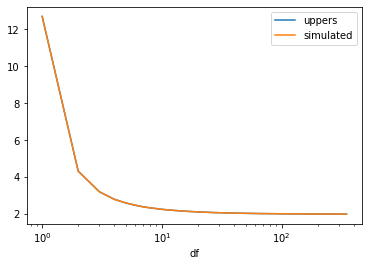

In [6]:
df2 = df.copy()
df2.loc[:, "simulated"] = simulated
df2.plot("df", logx=True)

No difference visually, that's a good sign...

Calculating absolute and relative errors:

In [7]:
df2.loc[:, "abs_err"] = (df2.simulated - df2.uppers)
df2.loc[:, "rel_err"] = (df2.simulated - df2.uppers) / df.uppers

<AxesSubplot:xlabel='df', ylabel='Absolute error'>

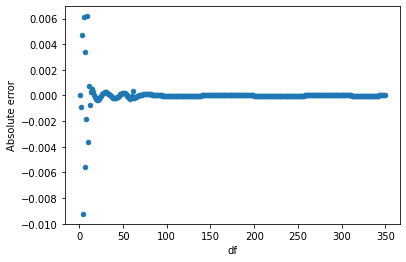

In [8]:
df2.plot.scatter("df", "abs_err", ylabel="Absolute error")

<AxesSubplot:xlabel='df', ylabel='Relative error (%)'>

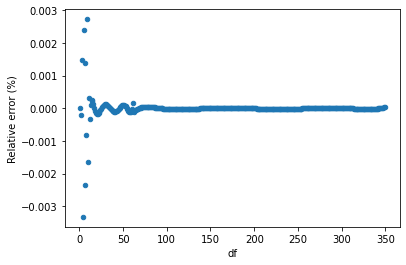

In [9]:
df2.plot.scatter("df", "rel_err", ylabel="Relative error (%)")

In [10]:
print(f"Maximum relative error: {df2.rel_err.abs().max():.2%}")

Maximum relative error: 0.33%


That should work!

Showing the first 30 rows:

In [11]:
df2.set_index('df')[:30]

,uppers,simulated,abs_err,rel_err
df,,,,
1,12.706205,12.706205,-2.573959e-10,-2.025750e-11
2,4.302653,4.301780,-8.731474e-04,-2.029323e-04
3,3.182446,3.187155,4.709047e-03,1.479694e-03
4,2.776445,2.767210,-9.235114e-03,-3.326237e-03
5,2.570582,2.576720,6.137862e-03,2.387733e-03
6,2.446912,2.450334,3.421744e-03,1.398393e-03
7,2.364624,2.359062,-5.562725e-03,-2.352478e-03
8,2.306004,2.304148,-1.855917e-03,-8.048194e-04
9,2.262157,2.268334,6.176574e-03,2.730391e-03


In [12]:
df2.describe()

,df,uppers,simulated,abs_err,rel_err
count,349.000000,349.000000,349.000000,3.490000e+02,3.490000e+02
mean,175.000000,2.034845,2.034844,-2.608646e-07,-1.195846e-07
std,100.891856,0.594073,0.594072,8.425207e-04,3.308377e-04
min,1.000000,1.966785,1.966860,-9.235114e-03,-3.326237e-03
25%,88.000000,1.969060,1.969066,-3.485767e-05,-1.768273e-05
50%,175.000000,1.973612,1.973652,6.872192e-08,3.475976e-08
75%,262.000000,1.987290,1.987332,3.420096e-05,1.737747e-05
max,349.000000,12.706205,12.706205,6.176574e-03,2.730391e-03


## Confirm javascript implemenation is the same as python

To generate in javascript:

```javascript
console.log(JSON.stringify({values:_.range(1,350).map(inv_tdist_05)}))
```

The output is copied below and compared to our python simulated data:

In [13]:
txt = '{"values":[12.7062047361747,4.301779582509312,3.1871553520088085,2.7672099913287695,2.576719698609363,2.4503335932468495,2.35906152566238,2.3041482182027515,2.2683337371729486,2.2245002959999134,2.2017053895295042,2.1780859284726732,2.1606116586136483,2.145318168287048,2.13192540154941,2.1201830443959344,2.1098683461365377,2.1007840212971045,2.0927562320459434,2.08563265114544,2.0792806054289166,2.073585299802687,2.068448121773319,2.0637850265000908,2.0595250023726566,2.0556086171139034,2.0519866444080206,2.0486187710537602,2.0454723846429066,2.04252144176394,2.0397454167309066,2.0371283308374872,2.03465786213627,2.032324535743218,2.0301209946673473,2.0280413511655966,2.026080618622904,2.024234223957484,2.022497600551303,2.0208658617057607,2.019333554622569,2.0178944949098296,2.0165416816133206,2.0152672927729807,2.014062761504584,2.012918932606644,2.0118262996924767,2.010775322847504,2.00975682681175,2.0087624796875003,2.0077853521722373,2.006820557316689,2.0058659708081494,2.00492303177898,2.0039976241402675,2.0031010384407653,2.002251014250958,2.0014728630723946,2.000800671772158,2.0002785865425583,1.9999621773861023,1.9987437069143683,1.9981671078955452,1.997603659522643,1.9970530657624572,1.9965150358777874,1.995989284364195,1.9954755308871324,1.9949735002194409,1.9944829221792224,1.994003531568078,1.9935350681097201,1.9930772763889537,1.9926299057910293,1.9921927104413641,1.9917654491456378,1.9913478853302549,1.99093978698318,1.9905409265951435,1.990151081101217,1.989770031822761,1.9893975644097397,1.9890334687834117,1.9886775390793867,1.9883295735910542,1.987989374713385,1.9876567488870995,1.9873315065432098,1.9870134620479303,1.9867024336479606,1.9863982434161382,1.9861007171974614,1.985809684555483,1.9855249787190759,1.9852464365295674,1.9849738983882452,1.984707208204234,1.9844462133427427,1.9841907645736814,1.9839407160206501,1.9836959251102977,1.9834562525220514,1.983221562138216,1.9829917209944465,1.9827665992305876,1.9825460700418862,1.9823300096305743,1.9821182971578224,1.9819108146960625,1.9817074471816825,1.9815080823680926,1.9813126107791592,1.9811209256630125,1.9809329229462223,1.9807485011883463,1.9805675615368479,1.980390007682385,1.9802157458144691,1.9800446845774955,1.9798767350271438,1.979711810587149,1.9795498270064436,1.9793907023166695,1.9792343567900617,1.9790807128977006,1.9789296952681386,1.9787812306463928,1.978635247853311,1.9784916777453083,1.9783504531744742,1.9782115089490484,1.9780747817942703,1.9779402103135968,1.9778077349502912,1.977677297949384,1.9775488433200024,1.9774223167980716,1.9772976658093868,1.9771748394330546,1.977053788365307,1.976934464883684,1.9768168228115877,1.9767008174832077,1.976586405708816,1.9764735457404328,1.9763621972378638,1.9762523212351057,1.9761438801071263,1.9760368375370105,1.9759311584834822,1.9758268091487907,1.9757237569469732,1.975621970472485,1.9755214194692008,1.975422074799787,1.9753239084154448,1.9752268933260224,1.9751310035705003,1.9750362141878446,1.9749425011882331,1.9748498415246514,1.9747582130648573,1.9746675945637207,1.9745779656359284,1.9744893067290645,1.9744015990970583,1.9743148247740039,1.97422896654835,1.9741440079374613,1.9740599331625495,1.973976727123975,1.9738943753769196,1.97381286410743,1.973732180108831,1.9736523107585102,1.9735732439950733,1.9734949682958693,1.9734174726548872,1.9733407465610215,1.9732647799767125,1.973189563316951,1.9731150874286594,1.97304134357044,1.9729683233926956,1.9728960189181195,1.972824422522556,1.9727535269162348,1.9726833251253697,1.9726138104741346,1.9725449765670058,1.9724768172714762,1.972409326701141,1.972342499199152,1.972276329322045,1.9722108118239352,1.9721459416410856,1.9720817138768438,1.972018123786952,1.971955166765225,1.9718928383296002,1.9718311341085586,1.9717700498279147,1.9717095812979797,1.9716497244010922,1.9715904750795215,1.9715318293237418,1.971473783161076,1.9714163326447092,1.9713594738430755,1.9713032028296136,1.9712475156728921,1.97119240842711,1.9711378771229593,1.971083917758868,1.9710305262926076,1.9709776986332717,1.970925430633627,1.970873718082835,1.970822556699542,1.970771942125342,1.9707218699186095,1.9706723355487021,1.970623334390535,1.9705748617195264,1.9705269127069098,1.9704794824154235,1.9704325657953645,1.9703861576810158,1.9703402527874445,1.970294845707671,1.9702499309102048,1.9702055027369578,1.9701615554015217,1.9701180829878193,1.9700750794491264,1.9700325386074633,1.9699904541533573,1.969948819645976,1.9699076285136317,1.9698668740546537,1.9698265494386356,1.9697866477080503,1.9697471617802351,1.9697080844497505,1.9696694083911057,1.9696311261618573,1.96959323020608,1.969555712858202,1.9695185663472183,1.96948178280127,1.9694453542525947,1.96940927264285,1.9693735298288046,1.9693381175884013,1.9693030276271912,1.9692682515851376,1.9692337810437914,1.969199607533835,1.9691657225430008,1.9691321175243561,1.969098783904959,1.969065713094892,1.9690328964966524,1.9690003255149293,1.9689679915667382,1.9689358860919326,1.9689040005640863,1.9688723265017445,1.9688408554800438,1.9688095791427087,1.9687784892144131,1.968747577513513,1.9687168359651541,1.9686862566147454,1.9686558316418057,1.9686255533741792,1.968595414302624,1.9685654070957685,1.968535524615441,1.9685057599323672,1.968476106342242,1.9684465573821681,1.9684171068474676,1.9683877488088617,1.9683584776300247,1.9683292879855072,1.9683001748790279,1.9682711336621366,1.9682421600532514,1.9682132501570626,1.9681844004843083,1.9681556079719194,1.9681268700035401,1.9680981844304126,1.9680695495926364,1.9680409643407955,1.9680124280579612,1.9679839406820596,1.9679555027286129,1.96792711531385,1.9678987801781909,1.9678704997100958,1.9678422769702895,1.9678141157163576,1.9677860204277073,1.9677579963309046,1.967730049425379,1.967702186509499,1.967674415207022,1.9676467439939085,1.9676191822255102,1.9675917401641314,1.967564429006956,1.9675372609143478,1.967510249038523,1.9674834075525867,1.9674567516799493,1.9674302977241083,1.9674040630987975,1.9673780663585156,1.9673523272294176,1.9673268666405792,1.9673017067556313,1.9672768710047754,1.9672523841171432,1.9672282721535608,1.9672045625396537,1.9671812840993452,1.9671584670887095,1.9671361432302037,1.9671143457472664,1.9670931093992925,1.9670724705169695,1.9670524670379934,1.9670331385431519,1.967014526292775,1.96699667326356,1.9669796241857693,1.9669634255807922,1.9669481257990793,1.9669337750584557,1.9669204254827894,1.9669081311410483,1.9668969480867098,1.9668869343975561,1.9668781502158295,1.9668706577887685,1.9668645215095006,1.9668598079583202]}'
df2.loc[:, "simulated_js"] = json.loads(txt)["values"]


(df2.simulated - df2.simulated_js).abs().describe()

count    3.490000e+02
mean     6.381397e-16
std      4.334341e-15
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.220446e-16
max      5.861978e-14
dtype: float64

Given this, there's very little diference between our python and javascript approximations.